In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input 

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
print(f'Tensorflow version: {tf.__version__}')
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

Tensorflow version: 2.4.1
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
root_folder = 'gdrive/MyDrive/Colab Notebooks/data/flower_images'

In [5]:
df = pd.read_csv(os.path.join(root_folder, 'flower_labels.csv'))
label = df['label'].tolist()
unique_labels = list(set(label))
print(unique_labels)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [6]:
flowers = []
for file in os.listdir(root_folder):
  if file.endswith('.png'):
    flowers.append(file)

print('Loaded {} images'.format(len(flowers)))

Loaded 210 images


In [7]:
IMG_SIZE = (224, 224)

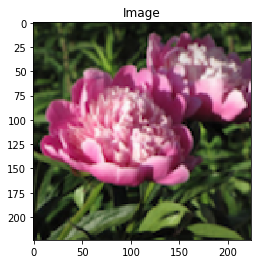

In [8]:
img = image.load_img(os.path.join(root_folder, flowers[0]), target_size=IMG_SIZE)
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
plt.figure()
plt.imshow(img)
plt.title('Image')
plt.show()

In [9]:
pretrained_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=True,
    input_shape=tuple([*IMG_SIZE, 3])
)

In [10]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
model = Model(inputs=pretrained_model.inputs, outputs=pretrained_model.layers[-2].output)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
def extract_features(file, model):
  img = image.load_img(file, target_size=IMG_SIZE)
  img = np.array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img) # img / 255.
  features = model.predict(img)
  return features

In [14]:
data = dict()

for flower in flowers:
  data[flower] = extract_features(os.path.join(root_folder, flower), model)

In [15]:
num_features = data[flowers[0]].shape
num_features

(1, 4096)

In [16]:
features = np.array(list(data.values())).reshape(-1, num_features[1])
features.shape

(210, 4096)

## PCA

In [17]:
pca = PCA(n_components=100, random_state=0)
pca.fit(features)
x = pca.transform(features)

In [18]:
print('Components before PCA: {}'.format(num_features[1]))
print('Components after PCA: {}'.format(pca.n_components))

Components before PCA: 4096
Components after PCA: 100


## K Mean cluster

In [19]:
kmeans = KMeans(n_clusters=len(unique_labels))
kmeans.fit(features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [20]:
kmeans.labels_

array([6, 1, 1, 4, 3, 9, 8, 6, 1, 1, 7, 3, 8, 6, 4, 8, 3, 9, 3, 6, 8, 9,
       5, 3, 3, 1, 6, 3, 7, 1, 9, 6, 3, 9, 1, 9, 6, 3, 3, 7, 6, 7, 1, 6,
       9, 6, 0, 9, 6, 1, 2, 9, 2, 6, 1, 6, 6, 3, 9, 3, 9, 3, 2, 6, 4, 6,
       5, 8, 6, 3, 4, 3, 5, 1, 6, 1, 1, 3, 3, 0, 1, 5, 4, 8, 6, 1, 7, 6,
       6, 7, 6, 3, 9, 5, 3, 6, 3, 1, 1, 6, 1, 8, 6, 5, 7, 9, 7, 1, 6, 6,
       5, 1, 0, 4, 1, 5, 1, 1, 5, 2, 0, 7, 6, 3, 5, 8, 5, 5, 6, 3, 1, 4,
       5, 9, 9, 3, 5, 6, 1, 6, 3, 6, 5, 3, 0, 1, 6, 7, 2, 5, 5, 4, 1, 1,
       8, 1, 5, 8, 3, 4, 6, 9, 6, 6, 5, 6, 1, 6, 9, 6, 3, 3, 8, 6, 9, 5,
       3, 1, 3, 8, 4, 1, 6, 2, 9, 6, 7, 9, 1, 2, 1, 4, 7, 0, 5, 8, 1, 7,
       8, 6, 3, 2, 1, 3, 3, 7, 8, 8, 7, 6], dtype=int32)

In [21]:
groups = {}
for file, cluster in zip(flowers, kmeans.labels_):
  if cluster not in groups.keys():
    groups[cluster] = []
    groups[cluster].append(file)
  else:
    groups[cluster].append(file)

In [22]:
def show_images(folder, imgs, title):
  num_rows = 1
  num_cols = 10 if len(imgs) > 10 else len(imgs)
  fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))
  for img, ax in zip(imgs, axs.flatten()):
    img_path = os.path.join(folder, img)
    ax.imshow(image.load_img(img_path, target_size=IMG_SIZE))
    ax.set_title(str(title))
    ax.axis('off')
  fig.tight_layout()
  plt.show()

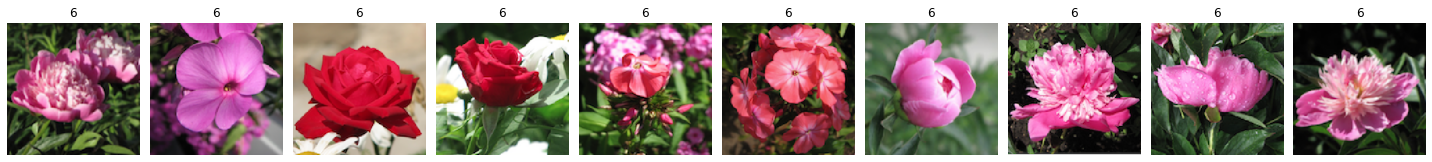

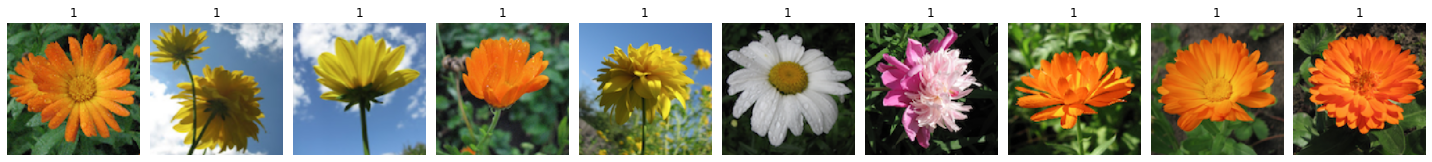

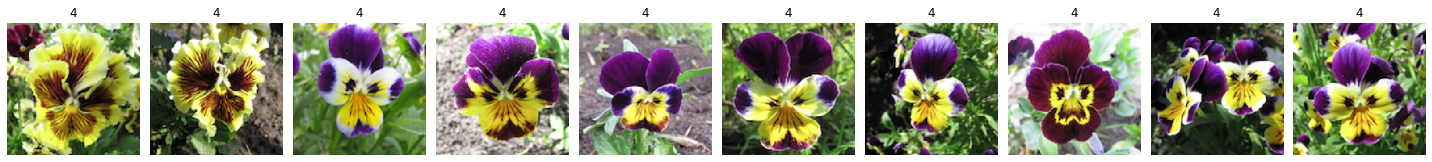

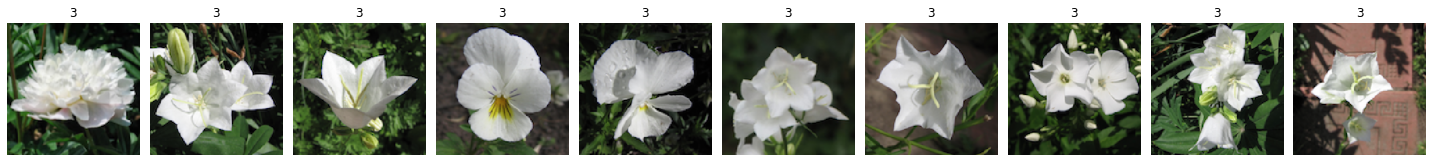

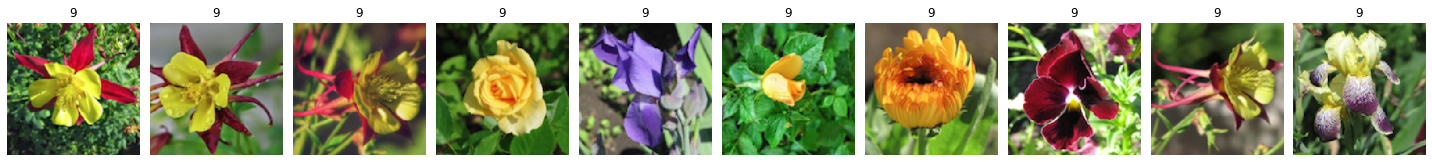

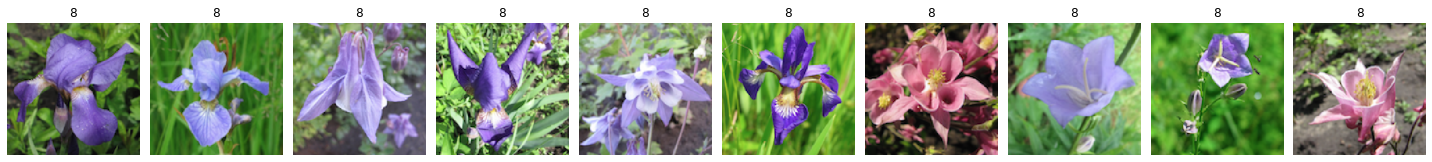

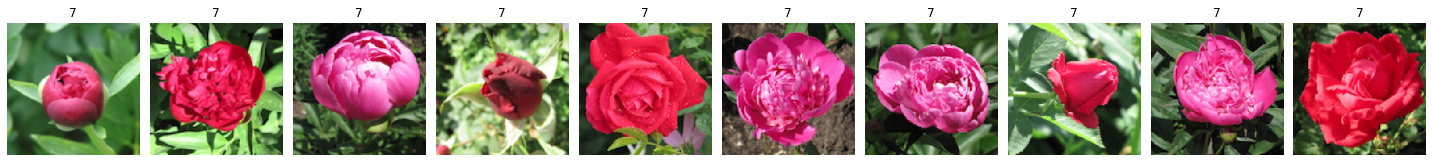

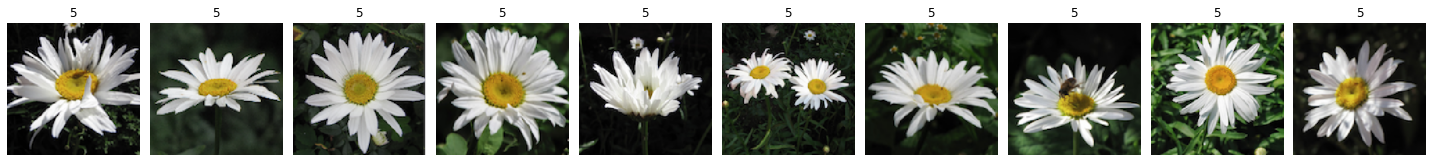

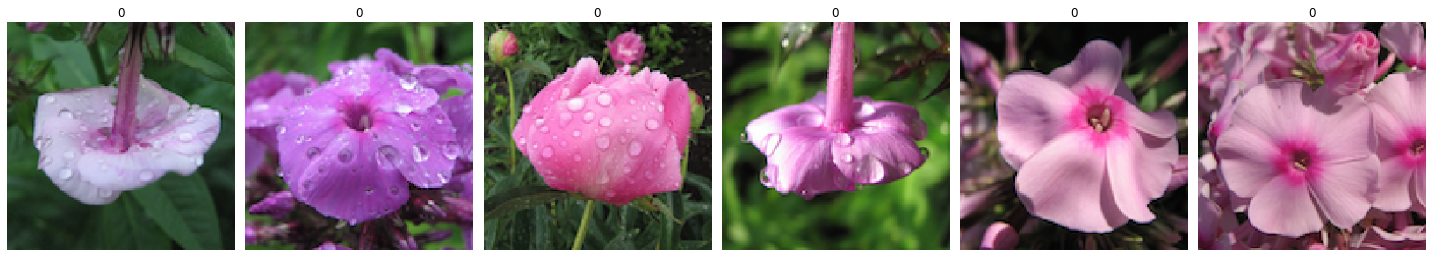

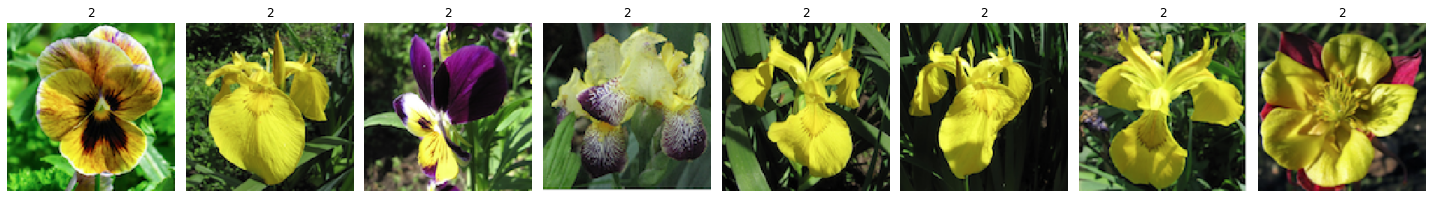

In [23]:
for cluster_set in groups.keys():
  show_images(root_folder, groups[cluster_set], cluster_set)